# LiCl ion pair dissociation in water
This notebook will show you how to perform NN assisted TPS on a molecular system with important solvent degrees of freedom (DoFs). This will greatly increase the sampling efficiency as compared to vanilla TPS and in addition yield a trained neural network which encodes the reaction mechanism. We can then susequently analyze the network to extract the learned reaction mechanism both quantitaviely and visually.

We will:
1. Setup openpathsampling for TwoWay shooting with random velocities
2. Decide on how to transform the full atomistic coordinates to descriptor space, i.e. we need to decide on the symmerty function cutoff and parameters.
3. Setup a pyramidal feed-forward keras-NN with a ResNet top.
4. Subsequently we will perform NN assisted TPS with (transformed) full atomistic inputs.
5. The analysis of the training process will show us if the training converged and the subsequent HIPR analysis should show us that the descriptors describing solvent DoFs are identified as the most relevant inputs.
6. Finally we will create a gradient colored movie for visual inspection of the reaction mechanism in molecular/cartesian space as encoded in the neural network.

### Basic imports

In [1]:
%matplotlib inline
import arcd
import os
import openpathsampling as paths
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 9, 6  # make the figures a bit bigger
import openpathsampling.engines.openmm as peng_omm
from simtk.openmm import app
import simtk.openmm as mm
import simtk.unit as unit
from openmmtools.integrators import VVVRIntegrator
import mdtraj as md

### Logging and working directory setup

In [2]:
# load LOGCONFIG dictionary
%run ../resources/logconf.py

# change to the working directory of your choice
wdir = '/home/think/scratch/pytorch_LiCl/'
#wdir = None
cur_dir = os.path.abspath(os.getcwd())
if wdir is not None:
    os.chdir(wdir)

# modify the logfile names to something meaningfull
LOGCONFIG['handlers']['stdf']['filename'] = 'LiCl_pytorch_simulation.log'
LOGCONFIG['handlers']['initf']['filename'] = 'LiCl_pytorch_init.log'
    
import logging.config
logging.config.dictConfig(LOGCONFIG)

## 1. Openpathsampling setup

### openMM/openpathsampling engine setup

In [3]:
# setup openMM integrator and system

# we will use the Joung and Cheatham ion force field for/with TIP3P water
# unfortunately this is not a part of the standard openMM forcefields, so we load the xml file from the forcefield folder in this repository
forcefield = app.ForceField(os.path.join(cur_dir, 'forcefield/tip3p_standard.xml'))

# load initial frame, contains one Li+, one Cl- and 244 TIP3P waters
pdb = app.PDBFile(os.path.join(cur_dir, 'LiCl_solv.pdb'))

# create openMM system
system = forcefield.createSystem(
    pdb.topology, 
    nonbondedMethod=app.PME, 
    nonbondedCutoff=1.0*unit.nanometers,
    constraints=app.HBonds, 
    rigidWater=True,
    ewaldErrorTolerance=0.0005
)

# create integrator
integrator = VVVRIntegrator(
    300*unit.kelvin, 
    1.0/unit.picoseconds, 
    2.0*unit.femtoseconds)
integrator.setConstraintTolerance(0.00001)

# template snapshot for openpathsampling to deduce topology and dimensionality for the engine and the storage
template = peng_omm.snapshot_from_pdb(os.path.join(cur_dir, 'LiCl_solv.pdb'))

# Note: usually not needed, openMM + openpathsampling will choose the fastest available by default
# but can be useful for a more fine grained control on how gets to use which GPUs
#openmm_properties = {'CUDAprecision': 'mixed'}

# openpathsampling engine options
engine_options = {
    'n_frames_max': 25000,  # maximal number of frames allowed in a trial trajectory
    'nsteps_per_frame': 10  # number of integration steps per trajectory frame
                  }
# create openpathsampling openMM engine
engine = peng_omm.Engine(template.topology,
                         system,
                         integrator,
                         #openmm_properties=openmm_properties,
                         options=engine_options,
                         )
# and give it a useful name
engine.name = '300K'

### Initial TP
Here we use a high temperature TP which is part of the repository, usually you will have to generate it yourself.

In [4]:
# load initial TP for LiCl (generated at high temp, 430K)
# we load the h5py trajectory and define the states from scratch
# for better machine interoperability and a smaller footprint in the repository
# (we could have also put everything into an openpathsampling storage, which would be more comfortable but much bigger)
initialTP_md = md.load(os.path.join(cur_dir, 'initial_TP_400K.h5'))  # initial TP as mdtraj trajectory
initialTP = peng_omm.trajectory_from_mdtraj(initialTP_md)  # initial TP as openpathsampling trajectory

### Define the states
Have a look at the potential of mean force along the interionic distance (generated via Umbrella sampling, followed by WHAM), which we can use to define the state boundaries in terms of the interionic distance.

<img src="figures/inter_ionic_PMF_with_states.png" style="max-width:30%; width: 30%"/>

In [5]:
# define the order parameter for the state definition
# it is just the interionic distance
ion_dist = paths.MDTrajFunctionCV("ion_dist", md.compute_distances, template.topology, atom_pairs=[[0, 1]])

# define the states using the previously defined order parameter
# from a previous long equilibrium run we know that the location of the bound and unbound states in terms of the ion distance
bound = (paths.CVDefinedVolume(ion_dist, lambda_min=0.01, lambda_max=0.23)).named("bound")
# similarly, without bothering with the labels:
unbound = (paths.CVDefinedVolume(ion_dist, .48, 1.0)).named("unbound")

In [6]:
# let openpathsampling construct all possible transitions between our states
tps = paths.TPSNetwork.from_states_all_to_all([bound, unbound])

## 2. Symmetry function parameters and setup

### First find a sensible cutoff radius for the symmetry functions
We need to decide how far from our central atoms the solvent should be described, we can do this by plotting the radial parts of the different symmerty functions we will use.

We then need to ensure overlapp between the single functions and in addition that all are zero if the solvent is further away from the central atom than our choosen cutoff.

In [7]:
# define functions for plotting only the radial part
def g2(r, rs, eta):
    # G2 has only a radial part 
    return np.exp(-eta*(r-rs)**2)

def g5_radial(r, rs, eta):
    # ignoring the angular part of G5, because it is always a factor \in [0, 1]
    # this is the value G5 would have for two atoms that are the same distance from the central atom
    # (and who have exactly the angular orientation that results in a maximal contribution from the angular part)
    return np.exp(-eta*(2*((r-rs)**2)))

def g_radial_worst_case(r, rs, eta):
    # this is the 'worst case' (highest value) G5 can have
    # one of the two atoms is exactly at the center of the probing shell and has maximal contribution
    # (as does the ignored angular part)
    return np.exp(-eta*(((r-rs)**2)))

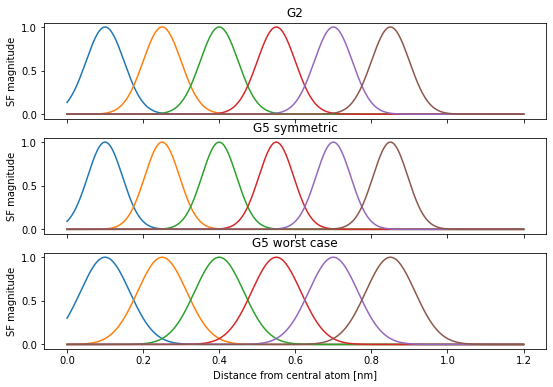

In [8]:
# actual plot
fig, axs = plt.subplots(nrows=3, sharex=True)

r = np.linspace(0, 1.2, 1000)
eta_g2 = 200  # controls the width of the probing shell, large values result in narrow and sharply defined shells
eta_g5 = 120  # same for G5 type, should be smaller since we will always have two atoms in the exponent
r_cs = [0.1, 0.25, 0.4, 0.55, 0.7, 0.85]  # center locations of the probing shells in radial space [in nm]

for ax, func, eta, title in zip(axs, [g2, g5_radial, g_radial_worst_case],
                                [eta_g2, eta_g5, eta_g5], ['G2', 'G5 symmetric', 'G5 worst case']):
    for r_c in r_cs:
        ax.plot(r, func(r, r_c, eta))
    ax.set_title(title)
    ax.set_ylabel('SF magnitude')
    if ax == axs[-1]:
        # xlabel only on last axis
        ax.set_xlabel('Distance from central atom [nm]')

### Define the descriptor transform function using the previously found symmerty function parameters
We will in addition add the interionic distance as a 'customCV' to see if it shows up as important in the relevance analysis. 

In [9]:
# symmerty functions first
cutoff = 0.6 # consider G5 worst case scenarios for cutoff!
# g2_parms are expected to be a list of lists, each sublist needs to contain [eta, r_s] 
g2_parms = [[200., 0.1], [200., 0.25], [200., 0.4]]#, [200., 0.55], [200., 0.7], [200., 0.85]]

# g5_parms are also expected to be a list of lists, here each sublist needs to contain
# [eta, r_s, zeta, lambda]
# here we just create the list of [eta, r_s] for G5,
# we add the missing parmeters below since:
# we use the same zetas, which influence the sharpness of the angular peaks, for all G5s at different probing radii
# and we use the same two lambda values [-1, +1], which influence the location of the maximum, i.e. at angle=0 or at angle=\pi
g5_etas_rs = [[120., 0.1],
              [120., 0.25],
              [120., 0.4],
              #[120., 0.55],
              #[120., 0.7],
              #[120., 0.85]
             ]
# all zetas for all G5, high zeta means sharp angular resultion
# Note: zeta must be an even number, using these powers of 2 empirically works well
zetas = [
        1,
        2,
        4,
        16,
        64,
        ]
# construct g5_parms from previously defined values
# combine every eta, r_s with all zetas and both possible lambda values
g5_parms = [[eta, r_s, zeta, lamb] for (eta, r_s) in g5_etas_rs for zeta in zetas for lamb in [+1., -1.]]

# combine G2 and G5 params into one list to pass to the SF transformation function
g_parms = [g2_parms, g5_parms]

# use mdtraj topology of the system and mdtraj atom selection language to
# generate the molecule indices (the atom indices of the protein/solute/molecule of interest whoose transition we want to sample),
# these will be the central atoms for the symmetry function calculation
# also generate the solvent indices (the atom indices of everything that should be considered solvent)
mol_idxs, solv_idxs = arcd.coords.symmetry.generate_indices(template.topology.mdtraj,  # the topology of the system
                                                            ['HOH'],  # list of strings with solvent resnames, here it is just water
                                                            solvent_atelements=[['O', 'H']],  # atom elements to consider for each solvent,
                                                                                              # expected to be a list of lists, one sublist per solvent resname
                                                            reactant_selection='index 0 or index 1'  # the selection string that selects the protein/reactant/solute,
                                                                                                     # i.e. our central atoms
                                                           )
# put all variables we need to pass to the symmerty function calculation into one dict
# makes it easier to use and pass around
sf_parms = {'mol_idxs': mol_idxs,  # see above
            'solv_idxs': solv_idxs,  # see above
            'g_parms': g_parms,  # the parameters defining the symmerty functions to calculate (see above)
            'cutoff': cutoff,  # distance from the central atom at which stop to consider the solvent/ do not calculate the symmetry functions anymore 
            # these two are needed to be able to approximately normalize the symmerty function values to be between 0 and 1
            # this is done by estimating the excpected number of atoms of each solvent assuming a uniform density
            'n_per_solv': [[1., 2.]],  # number of atoms per solvent molecule, need to be in the same order as the solvent_atelements above
                                       # here: each HOH contains 1 Oxygen and 2 Hydrogens
            'rho_solv': [33.]  # list of number densities of each solvent molecule [in 1/nm**3],
                               # 33. is simply the number density of water
           }
# create an openpathsampling FunctionCV out of our symmetry transformation function
# this has the benefit of beeing saved to the ops storage and working seamlessly with openpathsampling
# (and also does some other nice things for us like caching the results and therfore avoiding costly recalculations if used on the same trajectory/snapshot again)
sf_transform = paths.MDTrajFunctionCV('sf_transform',  #  name of the function, can be used to retrieve from OPS storage
                                      arcd.coords.symmetry.transform,  # symmerty function implementaion, which is part of arcd
                                      template.topology,  # every functionCV needs a topology
                                      **sf_parms  # unpack the dict of keyword args, these will be directly passed through to arcd.coords.symmetry.transform
                                     )


# define the interionic distance between Li+ and Cl- as customCV
custom_cv_func = md.compute_distances
dist_atom_indices = np.array([[0, 1]])  # Li+ has idx 0, Cl- has idx 1

# combine the symmetry functions and our customCV into one function to wrap it as an OPS FunctionCV again
# this will be the 'descriptor_transform' for our RCmodel, it transforms from molecular/cartesian space to the space in which the model learns
def transform_func(mdtra, sf_parms, dist_atom_indices):
    import mdtraj as md
    from arcd.coords.symmetry import sf
    import numpy as np
    return np.concatenate([sf(mdtra, **sf_parms),
                           md.compute_distances(mdtra, dist_atom_indices)],
                          axis=1
                         )
# wrap the function
descriptor_transform = paths.MDTrajFunctionCV('descriptor_transform',  # name in OPS
                                              transform_func,  # the function we just defined
                                              template.topology,  # topology
                                              sf_parms=sf_parms,  # keyword arg for our function
                                              dist_atom_indices=dist_atom_indices,  # second keyword arg for our function 
                                              cv_scalarize_numpy_singletons=False,  # to make sure it always returns a 2d array, even if called on trajectories with a single frame
                                             ).with_diskcache()  # enable caching of values

number of descriptors:  133


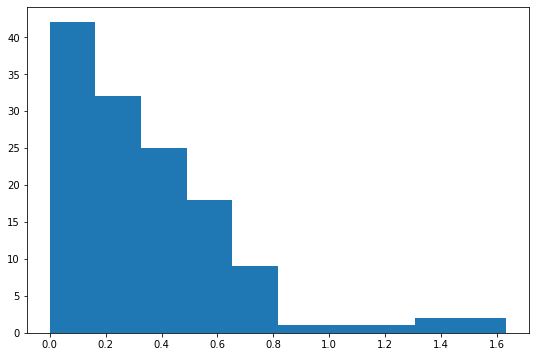

In [10]:
# get number of descriptors and have a look at the histo of values
trans_coords = descriptor_transform(template)
cv_ndim = trans_coords.shape[0]
plt.hist(trans_coords);
print('number of descriptors: ', cv_ndim)

## 3. Define the neural network

In [11]:
import torch.nn.functional as F
import torch

In [12]:
# create a pyramidal feed-forward architecture with a ResNet top part
n_lay_pyramid = 4  # number of layers in the pyramid
n_unit_top = 10  # number of units per layer in the top ResNet part
n_lay_top = 2  # number of ResUnits in the top part, results in n_lay_top * residual_n_skip layers
n_unit_base = descriptor_transform(template).shape[0]  # number of inputs to the NN/number of units in the first layer
print('number of input descriptors: ', n_unit_base)

# calculate the factor by which we reduce the number of units per layer in the pyramidal part from layer to layer
fact = (n_unit_top / n_unit_base)**(1./(n_lay_pyramid-1))

ffnet = arcd.pytorch.networks.FFNet(n_in=cv_ndim,
                                    n_hidden=[max(n_unit_top, int(n_unit_base * fact**i)) for i in range(n_lay_pyramid)],  # 4 hidden layer pyramidal network
                                    activation=F.elu,
                                   )

resnet = arcd.pytorch.networks.ResNet(n_units=n_unit_top, n_blocks=n_lay_top)

torch_model = arcd.pytorch.networks.ModuleStack(n_out=1,  # using a single output we will predict only p_B and use a binomial loss
                                                          # we could have also used n_out=n_states to use a multinomial loss and predict all states,
                                                          # but this is probably only worthwhile if n_states > 2 as it would increase the number of free parameters in the NN
                                                modules=[ffnet, resnet],  # modules is a list of initialized torch.nn.Modules from arcd.pytorch.networks
                                               )

# move model to GPU if CUDA is available
if torch.cuda.is_available():
    torch_model = torch_model.to('cuda')

# choose and initialize an optimizer to train the model
optimizer = torch.optim.Adam(torch_model.parameters(), lr=1e-3)

number of input descriptors:  133


In [13]:
torch.cuda.is_available()

True

### Wrap the NN as `arcd.RCmodel`

In [14]:
arcd_store = arcd.Storage(os.path.join(wdir, 'arcd_storage.h5'), mode='w')

In [15]:
model = arcd.pytorch.EEScalePytorchRCModel(nnet=torch_model,
                                           optimizer=optimizer,
                                           states=[bound, unbound],
                                           ee_params={'lr_0': 1e-3,  
                                                      'lr_min': 5e-5,  # lr_min = lr_0 / 20 is a good choice empirically
                                                      'epochs_per_train': 5,
                                                      'interval': 5,
                                                      'window': 75,
                                                      },
                                           descriptor_transform=descriptor_transform,
                                           cache_file=arcd_store,
                                           )

In [16]:
# create the trainset
trainset = arcd.TrainSet(n_states=2)

In [17]:
trainhook = arcd.ops.TrainingHook(model, trainset)
storehook = arcd.ops.ArcdStorageHook(arcd_store, model, trainset)
densityhook = arcd.ops.DensityCollectionHook(model, interval=20, first_collection=100)

In [18]:
# create the shooting point selector
# use default values: lorentzian selection with a scale parameter of 1.
selector = arcd.ops.RCModelSelector(model, [bound, unbound])

### 4. Setup and run NN-assited TwoWay shooting

In [19]:
# create the sampling move scheme, i.e. the recipe on how to generate new TP trials from previous ones in the MC chain
move_scheme = paths.MoveScheme(network=tps)
beta = 1. / (integrator.getTemperature() * unit.BOLTZMANN_CONSTANT_kB)
modifier = paths.RandomVelocities(beta=beta, engine=engine)
tw_strategy = paths.strategies.TwoWayShootingStrategy(modifier=modifier, selector=selector, engine=engine, group='TwoWayShooting')
move_scheme.append(tw_strategy)
move_scheme.append(paths.strategies.OrganizeByMoveGroupStrategy())
move_scheme.build_move_decision_tree()

In [20]:
# initial conditions object ofrom initial high temp transition path
initial_conditions = move_scheme.initial_conditions_from_trajectories(initialTP)

No missing ensembles.
No extra ensembles.


In [21]:
storage = paths.Storage('LiCl_ResNet_reduced_SFs.nc', 'w', template=template)

In [22]:
# create the PathSampling object
sampler = paths.PathSampling(storage=storage, sample_set=initial_conditions, move_scheme=move_scheme)

In [23]:
# attach the hooks
sampler.attach_hook(trainhook)
sampler.attach_hook(storehook)
sampler.attach_hook(densityhook)

In [24]:
# run TPS
sampler.run(500)

Working on Monte Carlo cycle number 500
Running for 22 minutes 33 seconds -  2.71 seconds per step
Estimated time remaining: 2 seconds
DONE! Completed 500 Monte Carlo cycles.


## 5. Analysis

### Look at the training process

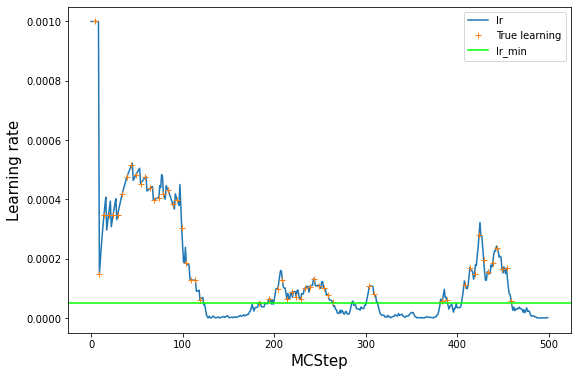

In [25]:
# lets have a look at the value of the learning rate over the course of training
# note however, that we did not train at every step, but just at every interval MCsteps
log_train = np.array(model.log_train_decision)
lr = log_train[:,1]
plt.plot(lr, label='lr')
# see where we really trained: everywhere where train=True
# set lr_true to NaN anywhere where we did not train to have a nice plot
lr_true = lr
lr_true[log_train[:,0] == False] = np.nan
plt.plot(lr_true, '+', label='True learning')
# lr_min as a guide to the eye
plt.axhline(model.ee_params['lr_min'], label='lr_min', color='lime')
plt.legend()
plt.xlabel('MCStep', size=15);
plt.ylabel('Learning rate', size=15);

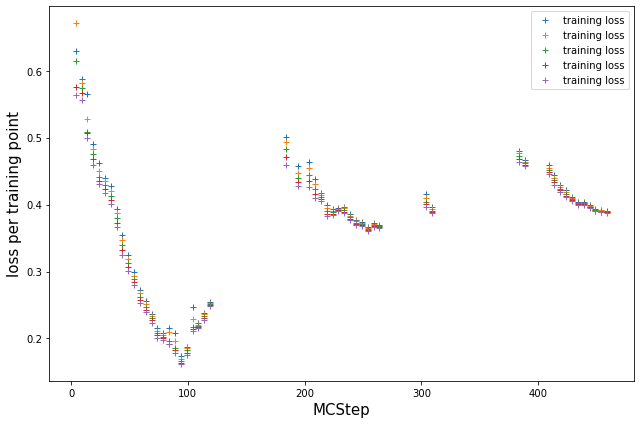

In [26]:
# resort such that we have a loss value per MCStep, NaN if we did not train at that step
train_loss = []
count = 0
for t in log_train[:, 0]:
    if t:
        train_loss.append(model.log_train_loss[count])
        count += 1
    else:
        train_loss.append([np.nan for _ in range(model.ee_params['epochs_per_train'])])
    
plt.plot(train_loss, '+', label='training loss')
plt.legend();
plt.ylabel('loss per training point', size=15)
plt.xlabel('MCStep', size=15)
plt.tight_layout()

### Plot all accepted TPs from the last 50 steps projected into the space of the ion distance CV

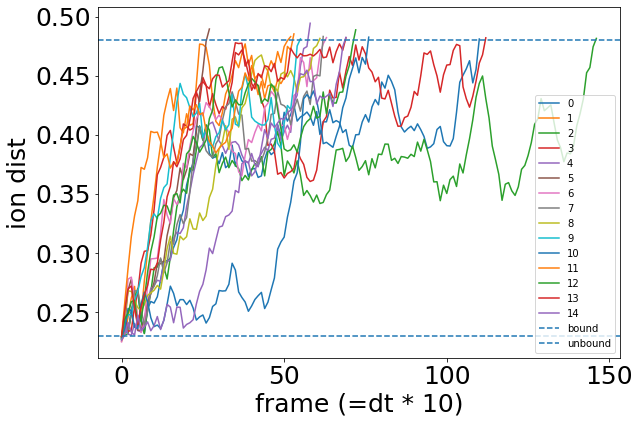

In [27]:
# first get them from storage by iterating over the last 50 steps
# check if it is accepted and if it goes from bound -> unbound
# else append the reversed trajectory for the plot to be nicer
# we use the ops volumes to see what the endstates are
ion_dist = storage.cvs.find('ion_dist')
bound = storage.volumes.find('bound')
unbound = storage.volumes.find('unbound')
tras = []
tras_ops = []
for step in storage.steps[-50:]:
    if step.change.canonical.accepted:
        if bound(step.change.canonical.trials[0].trajectory[0]):
            # directly calculate and append only the ion distance
            tras.append(ion_dist(step.change.canonical.trials[0].trajectory))
            tras_ops.append(step.change.canonical.trials[0].trajectory)
        else:
            # append reversed tra
            tras.append(ion_dist(step.change.canonical.trials[0].trajectory.reversed))
            tras_ops.append(step.change.canonical.trials[0].trajectory.reversed)

# actual plotting
for i, tra in enumerate(tras):
    plt.plot(np.arange(len(tra)), tra, label=i)
# labels and state definitions as a guide to the eye 
plt.axhline(bound.lambda_max, linestyle='--', label='bound')
plt.axhline(unbound.lambda_min, linestyle='--', label='unbound')
plt.xlabel('frame (=dt * 10)', size=25)
plt.ylabel('ion dist', size=25)
plt.tick_params(labelsize=25)
plt.legend()
plt.tight_layout()

In [28]:
# get history of accepts from storage
accepts = []
for step in storage.steps:
    if step.change.canonical.accepted:
        accepts.append(1.)
    else:
        accepts.append(0.)

### Plot expected and generated transitions to see if the model is doing a good job on unseen points
The difference between expected and gererated should become a flat line if the model is able to accurately predict future shooting results, i.e. it has predictive power on previously unseen shooting points.

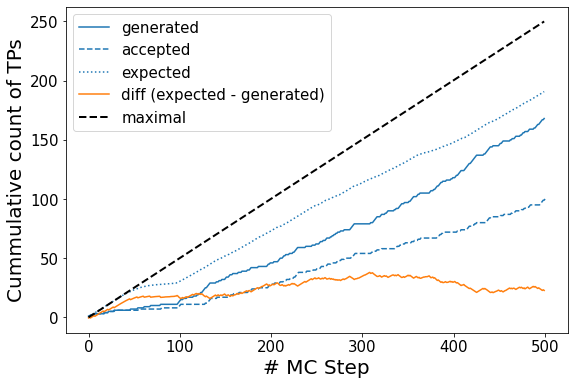

In [29]:
p_ex = np.array(model.expected_p)

l, = plt.plot(np.cumsum(trainset.transitions), label='generated');
plt.plot(np.cumsum(accepts), c=l.get_color(), ls='--', label='accepted');
plt.plot(np.cumsum(2*p_ex*(1 - p_ex)),c=l.get_color(), ls=':', label='expected');
plt.plot(np.cumsum(2*p_ex*(1 - p_ex))- np.cumsum(trainset.transitions), label='diff (expected - generated)')
plt.plot(np.linspace(0., len(trainset)/2., len(trainset)), c='k', ls='--', label='maximal', lw=2)
plt.legend(fontsize=15);
plt.tick_params(labelsize=15)
plt.ylabel('Cummulative count of TPs', size=20)
plt.xlabel('# MC Step', size=20);

### HIPR analysis to find most relevant inputs 

In [30]:
hipr = arcd.analysis.HIPRanalysis(model, trainset)

In [37]:
# directly do a HIPR plus, because it is less noisy than the canonical HIPR
hipr_losses, hipr_stds = hipr.do_hipr_plus(20)

### Plot relative importance for each coordinate as bar plot
- first half of the plot describes the oxygens of water around Li+ and Cl-, i.e. coordinate indices 0 to 66,
  of these the first 33 describe the oxygens of water around Li+, other 33 the oxygens around Cl-,
  inside each of these blocks of 33 the coordinates are ordered from close probing distance to high probing distance, i.e. by distance to the central atom
- coordinate indices 67 to 132 describe the hydrogens of water around Li+ and Cl-, here also the first 33 describe the hydrogens around Li+ and the next 33 describe   the hydrogens around Cl- and inside each of the blocks they are again ordered from close to distant
- the last index is for our customCV, the interionic distance

We should see that:
1. For the (positively charged) Li+ the (partialy negative) oxygens of water play a more important role than the hydrogens of water.
2. For the Cl- central atom the situation should be reversed, although usually it is less pronounced, in addition since the Cl- has a higher van-der-waals radius the    most relevant coordinates will be shifted to more distant probing shells (higher $r_s$)


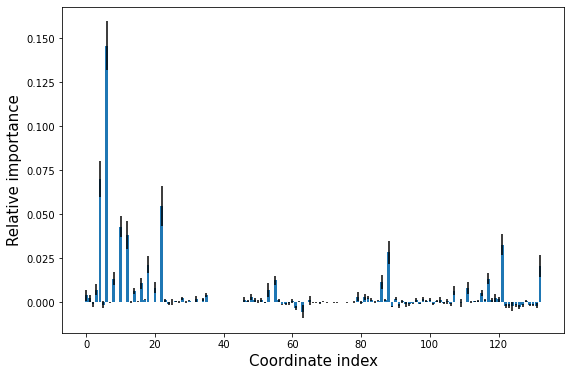

In [38]:
# plot the loss differences as a bar plot
loss_diffs = hipr_losses[:-1] - hipr_losses[-1]  # hipr_losses[-1] is the reference loss over the unaltered trainset
plt.bar(np.arange(len(loss_diffs)), loss_diffs, yerr=hipr_stds[:-1])
plt.xlabel('Coordinate index', size=15)
plt.ylabel('Relative importance', size=15);

In [39]:
# what are the most important contributors?
# can we get the single symmerty function parameters?
# we will use an arcd utility function to get the parameters belonging to every coordinate index
max_idxs = np.argsort(loss_diffs)[::-1]  # first get the array that would sort the indices from high importance to low importance
sf_parms = descriptor_transform.kwargs['sf_parms']  # need the sf_params to be able to get the parameters for every index

# iterate over the 20 most important contributors
print('reference loss:', hipr_losses[-1])  # this is the loss over the unaltered training set
for idx in max_idxs[:20]:
    print()
    print('loss for idx {:d}: '.format(idx), hipr_losses[idx])  # this is the loss we get if we randomize that coordinate, higher means higher importance
    print(arcd.coords.get_involved(idx, sf_parms=sf_parms, solvent_atoms=[['O', 'H']], solvent_resname=['HOH']))  # this function will extract the parameters for every index
    # it will print the type of transformation, i.e. 'SF' (symmetry function), 'IC' (internal coordinate) or 'customCV'
    # followed by the exact description of the transformation, which naturally varies between SF, IC and customCV
    # for SF we will output (in that order):
    #     the type (G2/G5)
    #     the parameters [eta, r_s, zeta, lambda], where zeta and lambda are applicable only to G5 type SFs
    #     the index of the central atom as given by the topology
    #     the name of the solvent, i.e. solvent resname from above
    #     the atom element of the solvent atom type this coordinate describes

reference loss: 0.4521218109130859

loss for idx 6:  0.597993106842041
('SF', ('G5', [120.0, 0.1, 2, -1.0], 0, 'HOH', 'O'))

loss for idx 4:  0.521979104232788
('SF', ('G5', [120.0, 0.1, 1, -1.0], 0, 'HOH', 'O'))

loss for idx 22:  0.5067482624053955
('SF', ('G5', [120.0, 0.25, 64, -1.0], 0, 'HOH', 'O'))

loss for idx 10:  0.49512931404113764
('SF', ('G5', [120.0, 0.1, 16, -1.0], 0, 'HOH', 'O'))

loss for idx 12:  0.49044683685302726
('SF', ('G5', [120.0, 0.1, 64, -1.0], 0, 'HOH', 'O'))

loss for idx 121:  0.48476084976196293
('SF', ('G5', [120.0, 0.25, 64, -1.0], 1, 'HOH', 'H'))

loss for idx 88:  0.480340315246582
('SF', ('G5', [120.0, 0.25, 64, -1.0], 0, 'HOH', 'H'))

loss for idx 18:  0.47340574836730953
('SF', ('G5', [120.0, 0.25, 4, -1.0], 0, 'HOH', 'O'))

loss for idx 132:  0.47274866600036625
('CustomCV', 0)

loss for idx 8:  0.4654798191070557
('SF', ('G5', [120.0, 0.1, 4, -1.0], 0, 'HOH', 'O'))

loss for idx 117:  0.4654416290283203
('SF', ('G5', [120.0, 0.25, 4, -1.0], 1, 'H

In [40]:
# just to remind you:
# Li+ has idx 0
# Cl- has idx 1
print('atom with index 0: ', template.topology.mdtraj.atom(0))
print('atom with index 1: ', template.topology.mdtraj.atom(1))

atom with index 0:  Li1-Li
atom with index 1:  Cl1-Cl


## 6. Gradient colored movie/trajectory
Using the chain rule we can calculate the derivative of the committor w.r.t to the cartesian coordinates of the system.

This enables us to create movies of the transitions where each atom is colored by the magnitude of the gradient of the committor w.r.t its movement.

In [65]:
from arcd.analysis import GradientMovieMaker

In [66]:
gmovie = GradientMovieMaker(trainhook.model, trainhook.model.descriptor_transform, storage.snapshots[-3].topology.mdtraj)

In [67]:
step = storage.steps[-3]
shot_snap = step.change.canonical.details.shooting_snapshot

In [75]:
# get indices of water around lithium and chloride from mdtraj and put them in a list
atom_indices = list(md.compute_neighbors(paths.Trajectory([shot_snap]).to_mdtraj(),  # take the shooting snapshot we want to create a movie around
                                         trainhook.model.descriptor_transform.kwargs['sf_parms']['cutoff'],  # cutoff for the symmetry function calculation,
                                                                                                             # everything further away can not contribute, so ignore it
                                         query_indices=trainhook.model.descriptor_transform.kwargs['sf_parms']['mol_idxs'],  # only look at our two central atoms and their neighbors
                                         haystack_indices=np.concatenate(trainhook.model.descriptor_transform.kwargs['sf_parms']['solv_idxs'][0]),  # only look at neighbors belonging to solvent
                                        )[0]
                   )
atom_indices += [0, 1]  # add the lithium and the chloride indices to the indices for gradient calculations
atom_indices = np.array(atom_indices, dtype=np.int32)

In [76]:
# find molecules for anchoring the movie, i.e. we will center on Li and Cl
mols = gmovie.topology.find_molecules()
anchor_mols = mols[0:2]
print(mols[0:2])

[{Li1-Li}, {Cl1-Cl}]


In [77]:
# finally make a gradient direction movie around the 3rd last shooting point
gmovie.movie_around_snapshot(shot_snap, 'gradient_movie.pdb', atom_indices=atom_indices, anchor_mols=anchor_mols)

ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


In [78]:
# or make a gradient colored pdb trajectory of a TP
# lets take one of the TP trajectories we plotted above
# best take a short one...the moviemaking can take quite a while...
print([len(t) for t in tras_ops])

[56, 173, 78, 43, 70, 94, 49, 73, 62, 53, 101, 74, 215, 35]


In [ ]:
tra_for_movie = tras_ops[-1]

In [ ]:
# get atom indices for gradient calculation for the trajectory
atom_indices = md.compute_neighbors(tra_for_movie.to_mdtraj(),
                                    trainhook.model.descriptor_transform.kwargs['sf_parms']['cutoff'],
                                    query_indices=trainhook.model.descriptor_transform.kwargs['sf_parms']['mol_idxs'],
                                    haystack_indices=np.concatenate(trainhook.model.descriptor_transform.kwargs['sf_parms']['solv_idxs'][0]),
                                    ) # here we take the full list, as the neighbours can change at every frame
# add Li and Cl indices for every frame
atom_indices = [list(frame_idxs) + [0, 1] for frame_idxs in atom_indices]
atom_indices = np.array(atom_indices, dtype=np.int32)

In [79]:
gmovie.color_by_gradient(tra_for_movie, 'TP_colored_by_gradient.pdb', atom_indices=atom_indices, anchor_mols=anchor_mols)

ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
ValueError: Buffer dtype mismatch, expected 'int32_t' but got 'long'


In [ ]:
arcd_store.close()

In [61]:
storage.sync_all()
storage.close()

RuntimeError: NetCDF: Not a valid ID